In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import cv2

from os import listdir
from PIL import Image
from numpy import savez_compressed, load
from os import listdir
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot 
from sklearn.metrics import accuracy_score
from functions import extract_face
from augmentation import rewrite_to_augmented
from functions import load_dataset

In [2]:
from tensorflow.keras.utils import to_categorical
from InceptionResNetV1 import InceptionResNetV1
from keras.models import load_model,Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
project_dirpath = os.getcwd()

In [5]:
dataset_train = os.path.join(project_dirpath, 'CE\\train\\')
dataset_val = os.path.join(project_dirpath, "CE\\test\\")
faces_npz = os.path.join(project_dirpath, "file\\ce_dataset.npz")

In [6]:
# Load the training data set
train_X, train_y = load_dataset(dataset_train)
# load test dataset
test_X, test_y = load_dataset(dataset_val)
# save arrays to one file in compressed format
savez_compressed(faces_npz, train_X, train_y, test_X, test_y)

Loading dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


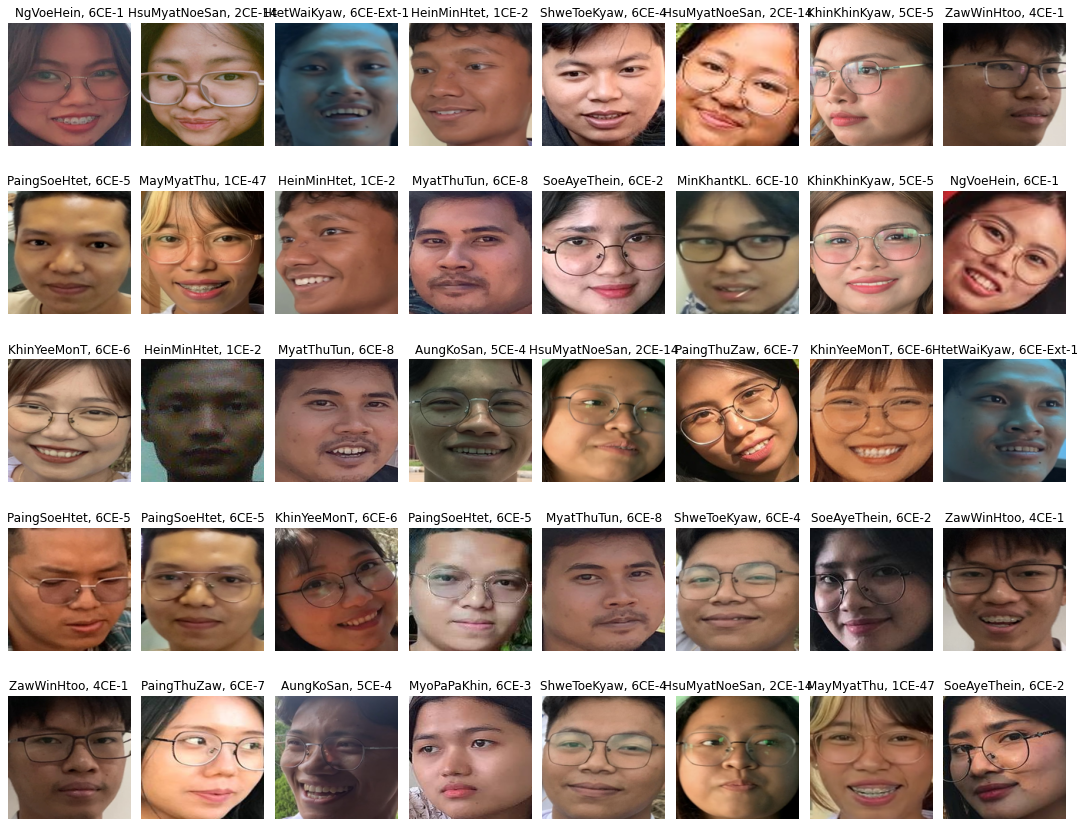

In [7]:
import random
# Function to plot 20 random images with labels
def plot_random_images_with_labels(images, labels, n=40):
    # Randomly select n images
    indices = random.sample(range(len(images)), n)
    selected_images = images[indices]
    selected_labels = labels[indices]
    
    # Plot the images in a grid
    fig, axes = plt.subplots(5, 8, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(n):
        axes[i].imshow(selected_images[i])
        axes[i].set_title(selected_labels[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display random 20 photos with labels from the training set
plot_random_images_with_labels(train_X, train_y)

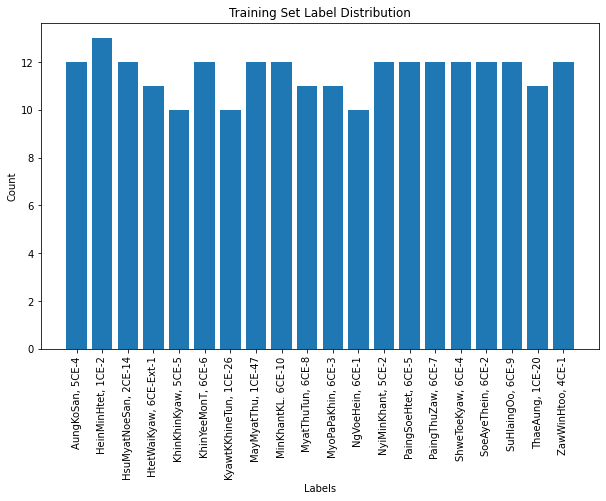

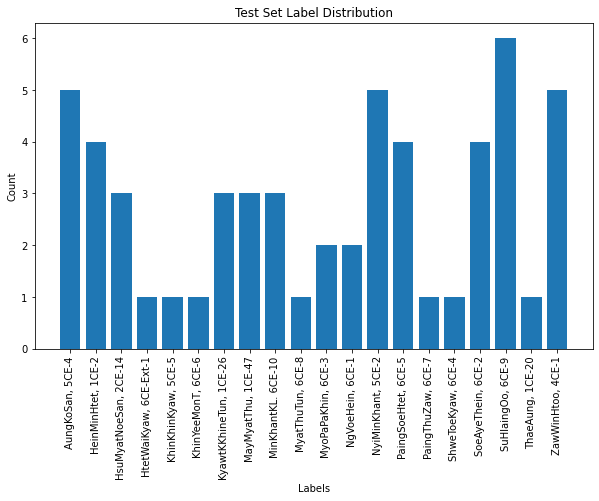

In [8]:
# Plot the label distribution
def plot_label_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(unique, counts, tick_label=unique)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.show()
    
# Display label distribution for training set
plot_label_distribution(train_y, 'Training Set Label Distribution')

# Display label distribution for test set
plot_label_distribution(test_y, 'Test Set Label Distribution')

In [9]:
# Load your dataset
data = load('file/ce_dataset.npz')
train_X, train_y, test_X, test_y = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Loaded:  (231, 160, 160, 3) (231,) (56, 160, 160, 3) (56,)


In [10]:
# Define the face preprocessing function
def face_preprocessor(image, required_size=(160, 160)):
    image = Image.fromarray(image)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    face_pixels = face_array.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    return face_pixels

In [11]:
# Preprocess the dataset
preprocessed_train_X = np.array([face_preprocessor(img) for img in train_X])
preprocessed_test_X = np.array([face_preprocessor(img) for img in test_X])

# Print the shapes to verify
print('Preprocessed: ', preprocessed_train_X.shape, preprocessed_test_X.shape)

Preprocessed:  (231, 160, 160, 3) (56, 160, 160, 3)


In [12]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

In [13]:
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
train_y_one_hot = to_categorical(train_y_encoded, num_classes=num_classes)
test_y_one_hot = to_categorical(test_y_encoded, num_classes=num_classes)

In [14]:
# Load the pre-trained model without classification layers
pretrained_model = InceptionResNetV1(weights_path='weights/MS_Celeb_weight.h5', input_shape=(160, 160, 3), include_top=False)

In [15]:
# Add new classification layers
x = pretrained_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [16]:
# Create the new model
model = Model(inputs=pretrained_model.input, outputs=predictions)
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Split the dataset into training and validation sets
train_X, val_X, train_y_one_hot, val_y_one_hot = train_test_split(preprocessed_train_X, train_y_one_hot, test_size=0.2, random_state=42)

In [19]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
datagen.fit(train_X)
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

In [21]:
# Define batch size and calculate the number of batches per epoch
batch_size = 16
steps_per_epoch = len(train_X) // batch_size

# Train the model with data augmentation and save the training history
history = model.fit(datagen.flow(train_X, train_y_one_hot, batch_size=batch_size), 
                    epochs=35, 
                    validation_data=(val_X, val_y_one_hot), 
                    callbacks=[lr_scheduler])

# Estimate the number of images processed
num_images_per_epoch = steps_per_epoch * batch_size
print(f"Estimated number of images processed per epoch: {num_images_per_epoch}")

# If you want to estimate for the whole training process
total_images_processed = num_images_per_epoch * 35  # 35 is the number of epochs
print(f"Estimated total number of images processed during training: {total_images_processed}")

# Print training accuracy and loss
training_accuracy = history.history['accuracy'][-1]
training_loss = history.history['loss'][-1]
print(f"Training Accuracy: {training_accuracy}")
print(f"Training Loss: {training_loss}")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(preprocessed_test_X, test_y_one_hot)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the trained model
model.save('file/My_Model.h5')


Epoch 1/35
12/12 [==============================] - 56s 3s/step - loss: 3.8980 - accuracy: 0.0652 - val_loss: 3.0209 - val_accuracy: 0.2128
Epoch 2/35
12/12 [==============================] - 33s 3s/step - loss: 3.0847 - accuracy: 0.2011 - val_loss: 2.4618 - val_accuracy: 0.3191
Epoch 3/35
12/12 [==============================] - 34s 3s/step - loss: 1.9775 - accuracy: 0.4293 - val_loss: 2.0617 - val_accuracy: 0.3617
Epoch 4/35
12/12 [==============================] - 34s 3s/step - loss: 1.6645 - accuracy: 0.4837 - val_loss: 1.6241 - val_accuracy: 0.4043
Epoch 5/35
12/12 [==============================] - 44s 4s/step - loss: 1.3772 - accuracy: 0.5815 - val_loss: 1.2756 - val_accuracy: 0.5532
Epoch 6/35
12/12 [==============================] - 63s 5s/step - loss: 1.0471 - accuracy: 0.7120 - val_loss: 1.0311 - val_accuracy: 0.7021
Epoch 7/35
12/12 [==============================] - 64s 5s/step - loss: 0.7768 - accuracy: 0.8098 - val_loss: 0.8625 - val_accuracy: 0.7447
Epoch 8/35
12/12 [==

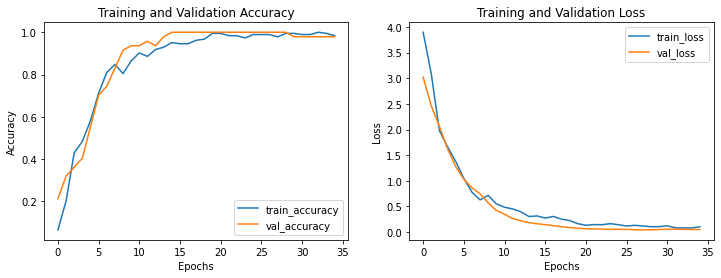

In [22]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [23]:
!pip install seaborn

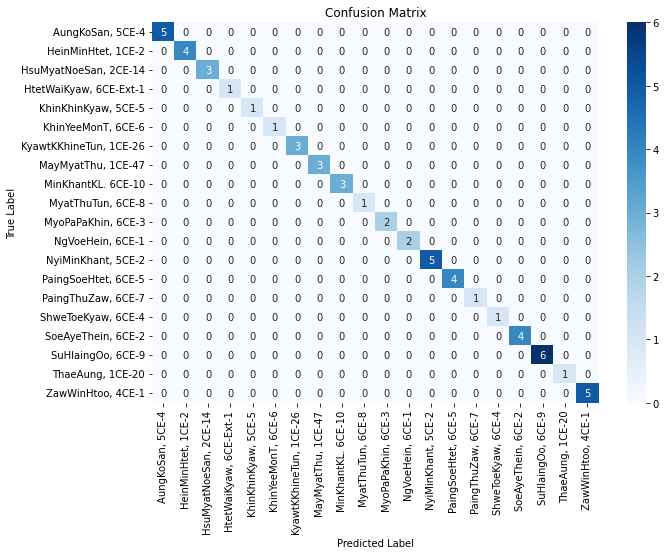

                        precision    recall  f1-score   support

      AungKoSan, 5CE-4       1.00      1.00      1.00         5
    HeinMinHtet, 1CE-2       1.00      1.00      1.00         4
 HsuMyatNoeSan, 2CE-14       1.00      1.00      1.00         3
HtetWaiKyaw, 6CE-Ext-1       1.00      1.00      1.00         1
   KhinKhinKyaw, 5CE-5       1.00      1.00      1.00         1
    KhinYeeMonT, 6CE-6       1.00      1.00      1.00         1
KyawtKKhineTun, 1CE-26       1.00      1.00      1.00         3
    MayMyatThu, 1CE-47       1.00      1.00      1.00         3
    MinKhantKL. 6CE-10       1.00      1.00      1.00         3
     MyatThuTun, 6CE-8       1.00      1.00      1.00         1
    MyoPaPaKhin, 6CE-3       1.00      1.00      1.00         2
      NgVoeHein, 6CE-1       1.00      1.00      1.00         2
    NyiMinKhant, 5CE-2       1.00      1.00      1.00         5
   PaingSoeHtet, 6CE-5       1.00      1.00      1.00         4
    PaingThuZaw, 6CE-7       1.00      

In [24]:
# Plot and visualize the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Make predictions on the test data
y_pred = model.predict(preprocessed_test_X)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true = np.argmax(test_y_one_hot, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Define class names
class_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

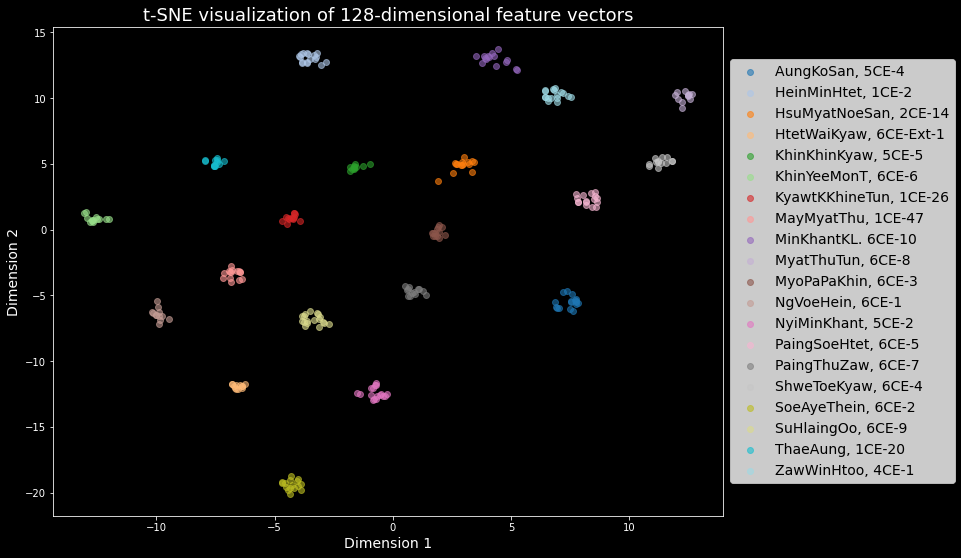

In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the embeddings from the .npz file
data = np.load('file/ce_embedding.npz')
train_X, train_y, test_X, test_y = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# Combine train and test embeddings for visualization
feature_vectors = np.concatenate((train_X, test_X), axis=0)
labels = np.concatenate((train_y, test_y), axis=0)

# Encode the string labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(feature_vectors)

# Get unique labels
unique_labels = np.unique(labels)

# Plot the t-SNE results for each class separately with a black background
plt.figure(figsize=(12, 9), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot each class with a different color
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], label=label, alpha=0.6)

# Set axis labels and title colors to white for visibility
plt.title("t-SNE visualization of 128-dimensional feature vectors", color='white', fontsize=18)
plt.xlabel("Dimension 1", color='white', fontsize=14)
plt.ylabel("Dimension 2", color='white', fontsize=14)

# Change tick colors to white for visibility
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Change axis line (spine) colors to white
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Create a legend with larger font size and white text color, placed outside the plot
legend = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1.0, 0.5))
for text in legend.get_texts():
    text.set_color('black')

plt.show()


Random Indices: [37, 1, 6, 41, 26, 44, 4, 27, 17, 21, 20, 10, 8, 55, 25, 48, 47, 46, 13, 9]
Selected True Labels (encoded): [13  0  1 16 10 17  0 11  6  8  7  2  1 19 10 17 17 17  4  2]
Selected Predicted Labels (encoded): [13  0  1 16 10 17  0 11  6  8  7  2  1 19 10 17 17 17  4  2]
Selected True Labels (decoded): ['PaingSoeHtet, 6CE-5' 'AungKoSan, 5CE-4' 'HeinMinHtet, 1CE-2'
 'SoeAyeThein, 6CE-2' 'MyoPaPaKhin, 6CE-3' 'SuHlaingOo, 6CE-9'
 'AungKoSan, 5CE-4' 'NgVoeHein, 6CE-1' 'KyawtKKhineTun, 1CE-26'
 'MinKhantKL. 6CE-10' 'MayMyatThu, 1CE-47' 'HsuMyatNoeSan, 2CE-14'
 'HeinMinHtet, 1CE-2' 'ZawWinHtoo, 4CE-1' 'MyoPaPaKhin, 6CE-3'
 'SuHlaingOo, 6CE-9' 'SuHlaingOo, 6CE-9' 'SuHlaingOo, 6CE-9'
 'KhinKhinKyaw, 5CE-5' 'HsuMyatNoeSan, 2CE-14']
Selected Predicted Labels (decoded): ['PaingSoeHtet, 6CE-5' 'AungKoSan, 5CE-4' 'HeinMinHtet, 1CE-2'
 'SoeAyeThein, 6CE-2' 'MyoPaPaKhin, 6CE-3' 'SuHlaingOo, 6CE-9'
 'AungKoSan, 5CE-4' 'NgVoeHein, 6CE-1' 'KyawtKKhineTun, 1CE-26'
 'MinKhantKL. 6CE-10' 'MayM

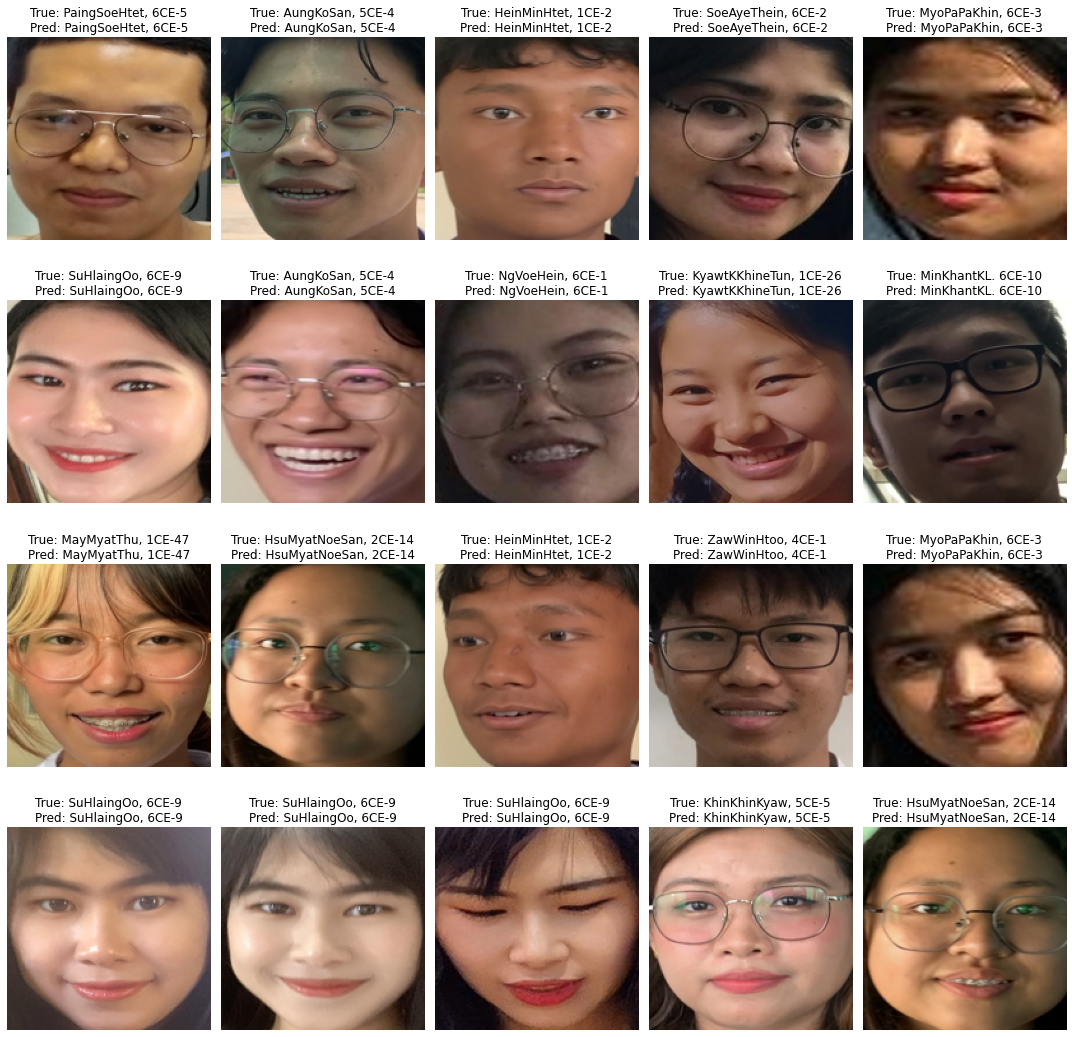

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Ensure consistent preprocessing function
def preprocess_images(images):
    face_array = np.asarray(images)
    face_pixels = face_array.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    return face_pixels

# Preprocess the test data
preprocessed_test_X = preprocess_images(test_X)

# Make predictions on the test data
y_pred = model.predict(preprocessed_test_X)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true = np.argmax(test_y_one_hot, axis=1)

# Define class names
class_names = label_encoder.classes_

# Plot 20 random images with their predicted and true labels
num_samples = 20
random_indices = random.sample(range(len(test_X)), num_samples)
selected_images = test_X[random_indices]

# Apply preprocessing to the selected images
preprocessed_selected_images = preprocess_images(selected_images)

# Predict labels for the selected images
selected_pred_probs = model.predict(preprocessed_selected_images)
selected_pred_labels = np.argmax(selected_pred_probs, axis=1)

# Get true labels for the selected images
selected_true_labels = np.argmax(test_y_one_hot[random_indices], axis=1)

# Decode labels to class names
true_class_names = label_encoder.inverse_transform(selected_true_labels)
pred_class_names = label_encoder.inverse_transform(selected_pred_labels)

# Diagnostic prints
print("Random Indices:", random_indices)
print("Selected True Labels (encoded):", selected_true_labels)
print("Selected Predicted Labels (encoded):", selected_pred_labels)
print("Selected True Labels (decoded):", true_class_names)
print("Selected Predicted Labels (decoded):", pred_class_names)

# Plot the images with predicted and true labels
plt.figure(figsize=(15, 15))
for i in range(num_samples):
    plt.subplot(4, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"True: {true_class_names[i]}\nPred: {pred_class_names[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
m=load_model('file/My_Model.h5')
m.summary()

Model: "model_861"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_862 (InputLayer)          [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_862[0][0]                  
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________